<a href="https://colab.research.google.com/github/Jeetsmeats/Full-Scale-Autonomous-Driving/blob/main/Full_scale_Autonomous_Driving_Jeet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full-Scale Autonomous Driving: Simulations Based Comparison

## Subject: AI4Robotics (ELEN90095)
## Authors:
- Yusuf Berdan Güzel (1051639)
- Gunjeet Singh (1170248)

## Install Dependencies (Only on Google Colab)

In [71]:
!pip install -q gymnasium stable_baselines3
!pip install osqp

In [72]:
!git clone https://gitlab.unimelb.edu.au/ai4r/ai4r-gym.git
!git clone https://github.com/Jeetsmeats/Full-Scale-Autonomous-Driving.git

Cloning into 'ai4r-gym'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 194 (delta 64), reused 27 (delta 10), pack-reused 64 (from 1)
Receiving objects: 100% (194/194), 160.29 KiB | 342.00 KiB/s, done.
Resolving deltas: 100% (87/87), done.
Cloning into 'Full-Scale-Autonomous-Driving'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 46 (delta 1), reused 11 (delta 1), pack-reused 35 (from 1)
Receiving objects: 100% (46/46), 96.73 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [73]:
%cd ai4r-gym

/content/ai4r-gym/ai4r-gym


## Library Imports:

In [74]:
import ai4rgym
from ai4rgym.envs.road import Road
import gymnasium as gym
import numpy as np
import random
from stable_baselines3 import PPO, SAC, DDPG
from utils import ensure_dir, ensure_dirs, eval_model, evaluate_policy
from utils import plot_rewards, plot_and_animate_trajectory
from evaluation.evaluation_for_autonomous_driving import simulate_policy
from evaluation.evaluation_for_autonomous_driving import plot_results_from_time_series_dict
import matplotlib.pyplot as plt
import osqp
import numpy as np
import scipy as sp
from scipy import sparse, linalg

## Environment Settings:

In [75]:
# SPECIFY THE VEHCILE PARAMETERS
bicycle_model_parameters = {
    "Lf" : 0.55*2.875,
    "Lr" : 0.45*2.875,
    "m"  : 2000.0,
    "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
    "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
    "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
    "delta_offset" : 0 * np.pi/180,
    "delta_request_max" : 45 * np.pi/180,
    "Ddelta_lower_limit" : -45 * np.pi/180,
    "Ddelta_upper_limit" :  45 * np.pi/180,
    "v_transition_min": 3.0,    # v_transition_min = 3.0 m/s
    "v_transition_max": 5.0,    # v_transition_max = 5.0 m/s
    "body_len_f" : (0.55*2.875) * 1.5,
    "body_len_r" : (0.45*2.875) * 1.5,
    "body_width" : 2.50,
}

# SPECIFY THE ROAD

# This road will not be used for training / evaluation
# this is just kept in place to initialize the environment
road_elements_list = [
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/400.0, "angle_in_degrees":30.0},
    {"type":"straight", "length":100.0},
]

# SPECIFY THE NUMERICAL INTEGRATION DETAILS
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,
    "num_steps_per_Ts" : 1,
}

# SPECIFY THE INITIAL STATE DISTRIBUTION

py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 30.0
v_init_max_in_kmh = 40.0

py_init_min = -1.0
py_init_max =  1.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

# SPECIFY THE TERMINATION PARAMETERS
termination_parameters = {
    "speed_lower_bound"  :  0.0,
    "speed_upper_bound"  :  (200.0/3.6),
    "distance_to_closest_point_upper_bound"  :  20.0,
    "reward_speed_lower_bound"  :  0.0,
    "reward_speed_upper_bound"  :  0.0,
    "reward_distance_to_closest_point_upper_bound"  :  0.0,
}

## Setting Observations:

In [76]:
# SPECIFY THE OBSERVATION PARAMETERS
observation_parameters = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "obs",
    "should_include_vx_sensor"                             :  "obs",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "obs",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "obs",
    "should_include_look_ahead_road_curvatures"            :  "info",
    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}

## Environment Creation:
- Generate a new environment

In [77]:
def create_env(road_randomization_params=None, road_elements_list=None):
    # If road_elements_list is provided, use it directly
    if road_elements_list is not None:
        road_elements = road_elements_list
    else:
        # Generate random road elements based on randomization parameters
        domain_randomizer = DomainRandomizationWrapper(None, road_randomization_params)
        road_elements = domain_randomizer.generate_random_road_elements_list()

    env = gym.make(
        "ai4rgym/autonomous_driving_env",
        render_mode=None,
        bicycle_model_parameters=bicycle_model_parameters,
        road_elements_list=road_elements,
        numerical_integration_parameters=numerical_integration_parameters,
        termination_parameters=termination_parameters,
        initial_state_bounds=initial_state_bounds,
        observation_parameters=observation_parameters,
    )

    # Set the integration method and time step
    Ts_sim = 0.05
    integration_method = "rk4"
    env.unwrapped.set_integration_method(integration_method)
    env.unwrapped.set_integration_Ts(Ts_sim)

    # Set the road condition
    env.unwrapped.set_road_condition(road_condition="wet")

    # Rescale actions and wrap the environment
    env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)

    # If using domain randomization, wrap the environment
    if road_randomization_params is not None:
        env = DomainRandomizationWrapper(env, road_randomization_params)

    return env

## RTI-MPC Policy

- Real-time Iteration Model Predictive Control Policy
- Included system dynamics and state-space model.
- Model failed to solve.

In [ ]:
class RTIMPC:

    def __init__(self, bicycle_model_parameters, Q, R,
                 s_initial, s_lower, s_upper, Ts, Nsim, state_ref, env):

        # State and action dimensions
        self.n_s = 4
        self.n_a = 2

        # Initial State
        self.s_initial = s_initial

        # Number of simulation points
        self.Nsim = Nsim

        # Define Model Parameters
        self.bicycle_model_parameters = bicycle_model_parameters
        self.Ts = Ts                  # Sampling Period

        # Prediction/Control Horizon
        self.N = 20

        # Sampling Frequency
        self.Ts = 0.05

        # Quadratic programmer
        self.qp = osqp.OSQP()

        # Cost Matrices
        self.Q = sparse.diags(Q, format="csc", dtype=np.float32)
        self.R = sparse.diags(R, format="csc", dtype=np.float32)

        # Define constraints
        self.s_lower = np.array(s_lower)
        self.s_upper = np.array(s_upper)
        self.a_lower = np.array([[-100], [np.deg2rad(-45)]])
        self.a_upper = np.array([[100], [np.deg2rad(45)]])

        # Model Parameters
        self.Cd = self.bicycle_model_parameters["Cd"]
        self.Cm = self.bicycle_model_parameters["Cm"]
        self.Lf = self.bicycle_model_parameters["Lf"]
        self.Lr = self.bicycle_model_parameters["Lr"]
        self.m = self.bicycle_model_parameters["m"]

        # State reference value
        self.p_ref = state_ref[0]
        self.d_ref = state_ref[1]
        self.mu_ref = state_ref[2]
        self.v_ref =  state_ref[3]

        # Lower and upper bounds of box constraints
        self.sa_lower = np.vstack([ self.s_lower , self.a_lower ])
        self.sa_upper = np.vstack([ self.s_upper , self.a_upper ])
        self.x_lower = np.vstack([ np.kron(np.ones((self.N,1),dtype=np.float32), self.sa_lower), self.s_lower ])
        self.x_upper = np.vstack([ np.kron(np.ones((self.N,1),dtype=np.float32), self.sa_upper), self.s_upper ])

        # Pre-allocate matrices for storing the results
        self.state_trajectory = np.empty((self.n_s, self.Nsim + 1), dtype=np.float32)
        self.action_trajectory = np.empty((self.n_s, self.Nsim), dtype=np.float32)

        # Set the initial condition in the first column
        self.state_trajectory[:, 0] = [
            self.s_initial[0].item() - self.p_ref.item(),
            self.s_initial[0].item() - self.d_ref.item(),
            self.s_initial[0].item() - self.mu_ref.item(),
            self.s_initial[0].item() - self.v_ref.item()
        ]

        # Set the initial state as the current state
        self.s_current = self.s_initial
        self.i = 1

        # Define the environment
        self.env = env

    def compute_action(self, observation, info_dict, terminated, truncated):

      a_current = np.zeros((1, 2))

      if self.i != 1:

        # Current State measurements
        p = observation["road_progress_at_closest_point"][0]
        d = observation["distance_to_closest_point"][0]
        mu = observation["heading_angle_relative_to_line"][0]
        v = observation["vx_sensor"][0]

        self.s_current = [p - self.p_ref, d - self.d_ref, mu - self.mu_ref, v - self.v_ref]

      curvature = observation["road_curvature_at_closest_point"][0]

      x_eq = [0, 0, 0, self.v_ref]
      u_eq = [0, 0]

      # Get the curvature
      kappa = self.env.unwrapped.road.convert_progression_to_curvature(np.array([curvature]))

      # Discrete-time matrices
      A, B, Aeq, Beq = self.discrete_time_dynamics(x_eq, u_eq, kappa)
      A_for_osqp = sparse.vstack([ Aeq , sparse.eye(self.N*(self.n_s+self.n_a)+self.n_s,format="csc")],format="csc")
      l_for_osqp = np.vstack([ Beq , self.x_lower ])
      u_for_osqp = np.vstack([ Beq , self.x_upper ])

      # DARE Solution
      P = self.solve_discrete_are(A, B, self.Q, self.R)

      # Objective function matrix
      QR = sparse.block_diag([self.Q, self.R])
      H = sparse.block_diag([ sparse.kron(sparse.eye(self.N,format="csc"), QR), P],format="csc")

      # Set up the QP solver for each time step.
      self.qp.setup(P=2*H,
        q=np.zeros(H.shape[1]),
        A=A_for_osqp,
        l=l_for_osqp,
        u=u_for_osqp,
        verbose=False,
      )

      # Update the constraint vector with the current state
      l_for_osqp[0:self.n_s] = self.s_current
      u_for_osqp[0:self.n_s] = self.s_current

      # Update the OSQP object with the current state
      self.qp.update(l=l_for_osqp, u=u_for_osqp)

      res = self.qp.solve()

      if res.info.status != 'solved':
        raise ValueError('QSQP did not solve the problem')

      # Update the constraint vector with the current state
      l_for_osqp[0:self.n_s] = self.s_current
      u_for_osqp[0:self.n_s] = self.s_current

      # Update the OSQP object with the current state
      self.qp.update(l=l_for_osqp, u=u_for_osqp)

      # Solve the optimization program
      osqp_result = self.qp.solve()

      # Extract the status string
      osqp_status_string = osqp_result.info.status

      # Display the status if it is anything other than success
      if (osqp_status_string != "solved"):
        raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

      # Extract the optimal solution
      x_optimal = osqp_result.x

      # Extract the first action from the optimal solution
      a_current[:][0] = x_optimal[self.n_s: (self.n_s + self.n_a)]

      # Compute the next state
      s_next = A @ self.s_current + B @ a_current

      # Store the results
      self.state_trajectory[:][self.i+1] = s_next[:,0]
      self.action_trajectory[:][self.i] = a_current[:,0]
      # self.x_optimal_trajectory[:][self.i] = x_optimal
      # self.solver_run_times[self.i] = osqp_result.info.run_time
      # self.solve_status_val[self.i] = osqp_result.info.status_val

      # Iterate the current state
      self.s_current = s_next
      self.i += 1

      F_action = a_current[0, 0]
      steer_action = a_current[1, 0]

      # Return the actions as a numpy array
      return np.array([F_action, steer_action], dtype=np.float32)

    def solve_discrete_are(self, A, B, Q, R):
      """
      Solve the discrete Ricatti Equation.
      """
      # Riccati solution
      P_dense = linalg.solve_discrete_are(A.toarray(),B.toarray(),Q.toarray(),R.toarray())

      # Convert P to be in sparse format
      P = sparse.csc_matrix(P_dense, shape=(self.n_s, self.n_s), dtype=np.float32)

      # DARE Solution
      return P

    def discrete_time_dynamics(self, x_eq, u_eq, kappa):
      """
      Derive discrete time dynamics
      """
      # Set Equilibrium Points
      p_eq = x_eq[0]
      d_eq = x_eq[1]
      mu_eq = x_eq[2]
      v_eq = x_eq[3]

      # Action Equilibrium Points
      F_eq = u_eq[0]
      steer_eq = u_eq[1]

      # State Dynamics
      A12 = -(kappa * v_eq * np.cos(mu_eq)) / (np.power((1 + d_eq * kappa), 2))
      A13 = -(v_eq * np.sin(mu_eq)) / (1 + d_eq * kappa)
      A14 = (np.cos(mu_eq)) / (1 + d_eq * kappa)

      A23 = v_eq * np.cos(mu_eq)
      A24 = np.sin(mu_eq)

      A32 = ((kappa ** 2) * v_eq * np.cos(mu_eq)) / (np.power((1 + d_eq * kappa), 2))
      A33 = (kappa * v_eq * np.sin(mu_eq)) / (1 + d_eq * kappa)
      A34 = ((np.tan(steer_eq)) / (self.Lr)) - ((kappa * np.cos(mu_eq)) / (1 + d_eq * kappa))

      A44 = (2 / self.m) * self.Cd * v_eq * np.sign(v_eq)

      A12 = A12.item()
      A13 = A13.item()
      A14 = A14.item()
      A23 = A23.item()
      A24 = A24.item()
      A32 = A32.item()
      A33 = A33.item()
      A34 = A34.item()
      A44 = A44.item()

      # Input Dynamics
      B32 = (v_eq / self.Lr) * (1 / np.power(np.cos(steer_eq), 2))
      B41 = (self.Cm / self.m) * v_eq * np.sign(v_eq)

      B32 = B32.item()
      B41 = B41.item()

      # Continuous State-Space
      Ac = np.array([
      [ 0.,  A12, A13, A14],
      [ 0., 0., A23, A24],
      [ 0., A32, A33, A34],
      [ 0., 0., 0., A44]
      ], dtype=np.float32)

      Bc = np.array([
      [ 0., 0.],
      [ 0., 0.],
      [ 0., B32],
      [ B41, 0.]
      ], dtype=np.float32)

      # Compute the discrete time dynamics matrices
      # > Stack the matrices
      Mc = np.vstack([ np.hstack([Ac,Bc]) , np.zeros((self.n_a,self.n_s+self.n_a),
      dtype=np.float32) ])

      # Matrix Exponential
      Md = linalg.expm( Mc * self.Ts )

      # Discrete-time State Space
      Ad = Md[0:self.n_s,0:self.n_s]
      Bd = Md[0:self.n_s,self.n_s:(self.n_s+self.n_a)]

      # Convert Ad and Bd to be in sparse format
      A = sparse.csc_matrix(Ad, shape=(self.n_s,self.n_s), dtype=np.float32)
      B = sparse.csc_matrix(Bd, shape=(self.n_s,self.n_a), dtype=np.float32)

      # Matrix for all time steps of the dynamics
      AB = sparse.hstack([A,B])

      negI_zero_block = sparse.hstack([ -sparse.eye(self.n_s,format="csc"), sparse.csc_matrix((self.n_s,self.n_a)) ])
      zero_negI_col = sparse.vstack([sparse.csc_matrix(((self.N-1)*self.n_s,self.n_s)), -sparse.eye(self.n_s,format="csc")])
      ABI_stacked = \
        sparse.hstack([ sparse.kron(sparse.eye(self.N,format="csc") , AB) ,
      sparse.csc_matrix((self.N*self.n_s,self.n_s)) ]) \
        + \
        sparse.hstack([ sparse.kron(sparse.eye(self.N,k=1,format="csc"),negI_zero_block) ,
      zero_negI_col ])

      # Matrix for selecting the first state
      s0_selector = sparse.hstack([ sparse.eye(self.n_s,format="csc"), sparse.csc_matrix((self.n_s,self.N*(self.n_s+self.n_a)))])

      # Stacking the above two together
      Aeq = sparse.vstack([ s0_selector , ABI_stacked ])
      Beq = np.vstack([ self.s_initial , np.zeros((self.N * self.n_s,1)) ])
      return A, B, Aeq, Beq

## Baseline Policy Implementation


In [78]:
from collections import deque

class BaselinePolicyRewardWrapper(gym.RewardWrapper):

    def __init__(self, env):
        super(BaselinePolicyRewardWrapper, self).__init__(env)

        # Performance metric initialisation
        self.total_distance = 0
        self.total_speed = 0
        self.min_speed = 0
        self.max_speed = 0
        self.time_above_vlimit = 0
        self.time_above_dlimit = 0
        self.n_speed_violations = 0
        self.n_distance_violations = 0
        self.total_steer = 0
        self.total_ang_velocity = 0
        self.duration_of_speed_limit = []
        self.duration_of_distance_limit = []

        self.curr_time_over_dlimit = 0
        self.curr_time_over_tlimit = 0

        self.distance_flag = False
        self.speed_flag = False

        self.max_dist = 0

        self.vmax = 30.0 / 3.6
        self.Ts = 0.05

        self.N = 1

        self.omega_prev = 0
        self.progress = 0

        self.velocities = np.array([])

    def get_performance(self):
        avg_speed = self.total_speed / self.N
        avg_distance = self.total_distance / self.N
        avg_steer = self.total_steer / self.N
        avg_ang_velocity = self.total_ang_velocity / self.N

        min_speed = self.min_speed
        max_speed = self.max_speed
        max_distance = self.max_dist
        time_above_vlimit = self.time_above_vlimit
        time_above_dlimit = self.time_above_dlimit
        n_speed_violations = self.n_speed_violations
        n_distance_violations = self.n_distance_violations

        avg_speed_violation_time = np.mean(self.duration_of_speed_limit)
        avg_distance_violation_time = np.mean(self.duration_of_distance_limit)

        std_speed = np.std(self.velocities)

        return {
            "avg_speed": avg_speed,
            "avg_distance": avg_distance,
            "avg_steer": avg_steer,
            "avg_ang_velocity": avg_ang_velocity,
            "min_speed": min_speed,
            "max_speed": max_speed,
            "max_distance": max_distance,
            "time_above_vlimit": time_above_vlimit,
            "time_above_dlimit": time_above_dlimit,
            "n_speed_violations": n_speed_violations,
            "n_distance_violations": n_distance_violations,
            "avg_speed_violation_time": avg_speed_violation_time,
            "avg_distance_violation_time": avg_distance_violation_time,
            "std_speed": std_speed
        }

    def step(self, action):
        """
        RL Policy time step.
        """
        observation, reward, terminated, truncated, info = self.env.step(action)
        steer_angle = action[1]

        # Observations
        distance_to_line = abs(observation["distance_to_closest_point"][0])
        vx = observation["vx_sensor"][0]
        theta = observation["heading_angle_relative_to_line"][0]
        omega = observation["heading_angular_rate_gyro"][0]
        progress = observation["road_progress_at_closest_point"][0]

       # Calculate angular acceleration
        alpha = (omega - self.omega_prev) / self.Ts
        omega_prev = omega

        if distance_to_line < 1 and abs(theta) < np.pi / 3:
          reward += 0.15
        else:
          reward -= 0.1

        if vx >= (20.0 / 3.6) and vx <= (60.0 / 3.6):
          reward += 0.5

        if vx < (20.0 / 3.6) and vx > (80.0 / 3.6):
          reward -= 0.2

        if omega < 0.5:
          reward += 0.5

        if progress + 3 > self.progress:
          reward += 0.5

        self.progress = progress

        self.performance_metrics(distance_to_line, vx, theta, omega, progress, steer_angle)
        self.N += 1
        return observation, reward, terminated, truncated, info

    def performance_metrics(self, distance_to_line, vx, theta, omega, progress, steer):
        self.total_distance += distance_to_line
        self.min_speed = min(self.min_speed, vx)
        self.max_speed = max(self.max_speed, vx)

        self.max_dist = max(self.max_dist, distance_to_line)

        if vx > self.vmax and not self.speed_flag:
            self.speed_flag = True
            self.n_speed_violations += 1
        elif vx <= self.vmax and self.speed_flag:
            self.speed_flag = False
            self.duration_of_speed_limit.append(self.curr_time_over_tlimit)
            self.curr_time_over_tlimit = 0

        if distance_to_line > 1 and not self.speed_flag:
            self.time_above_dlimit += self.Ts
            self.n_distance_violations += 1
        elif distance_to_line <= 1 and self.distance_flag:
            self.distance_flag = False
            self.duration_of_distance_limit.append(self.curr_time_over_dlimit)
            self.curr_time_over_dlimit = 0

        if self.speed_flag:
          self.time_above_vlimit += self.Ts
          self.curr_time_over_tlimit += self.Ts

        if self.distance_flag:
          self.time_above_dlimit += self.Ts
          self.curr_time_over_dlimit += self.Ts

        self.total_steer += abs(steer)
        self.total_ang_velocity += abs(omega)

        self.total_speed += abs(vx)

        self.velocities = np.array(vx)


## Domain Randomization Wrapper:
- Designate a domain randomization wrapper for random generation of the terrain in training.



In [79]:
class DomainRandomizationWrapper(gym.Wrapper):
    def __init__(self, env, road_randomization_params=None):
        super(DomainRandomizationWrapper, self).__init__(env)
        self.road_randomization_params = road_randomization_params

    def generate_random_road_elements_list(self):
        params = self.road_randomization_params or {}
        num_elements_range = params.get('num_elements_range', (2, 5))
        straight_length_range = params.get('straight_length_range', (50.0, 200.0))
        curvature_range = params.get('curvature_range', (-1/500.0, 1/500.0))
        angle_range = params.get('angle_range', (10.0, 60.0))

        road_elements = []
        num_elements = random.randint(*num_elements_range)

        for _ in range(num_elements):
            element_type = random.choice(['straight', 'curved'])
            if element_type == 'straight':
                length = random.uniform(*straight_length_range)
                road_elements.append({"type": "straight", "length": length})
            else:
                curvature = random.uniform(*curvature_range)
                angle = random.uniform(*angle_range)
                road_elements.append({
                    "type": "curved",
                    "curvature": curvature,
                    "angle_in_degrees": angle
                })
        return road_elements

    def reset(self, **kwargs):
        # Generate a new random road
        road_elements_list = self.generate_random_road_elements_list()
        self.env.unwrapped.road_elements_list = road_elements_list
        self.env.unwrapped.road = Road(epsilon_c=(1/10000), road_elements_list=road_elements_list)
        self.env.unwrapped.total_road_length = self.env.unwrapped.road.get_total_length()
        self.env.unwrapped.total_road_length_for_termination = max(
            self.env.unwrapped.total_road_length - 0.1,
            0.9999 * self.env.unwrapped.total_road_length
        )
        # Call the original reset method
        return self.env.reset(**kwargs)

### Visualizing Random Roads:

## Setting up Training/Evaluation Environments:

In [80]:
### ------------- MAKE CHANGES TO THE ROAD RANDOMIZATION PARAMS HERE ------- ###
# Difficulty levels for curriculum learning
road_randomization_params_levels = {
    1: {
        'num_elements_range': (4, 8),
        'straight_length_range': (150.0, 300.0),
        'curvature_range': (-1/1000.0, 1/1000.0),
        'angle_range': (5.0, 15.0),
    },
    2: {
        'num_elements_range': (5, 10),
        'straight_length_range': (100.0, 200.0),
        'curvature_range': (-1/800.0, 1/800.0),
        'angle_range': (10.0, 30.0),
    },
    3: {
        'num_elements_range': (10, 12),
        'straight_length_range': (80.0, 150.0),
        'curvature_range': (-1/500.0, 1/500.0),
        'angle_range': (20.0, 45.0),
    },
    4: {
        'num_elements_range': (12, 17),
        'straight_length_range': (60.0, 120.0),
        'curvature_range': (-1/300.0, 1/300.0),
        'angle_range': (30.0, 60.0),
    },
    5: {
        'num_elements_range': (16,18),
        'straight_length_range': (50.0, 100.0),
        'curvature_range': (-1/200.0, 1/200.0),
        'angle_range': (45.0, 90.0),
    },
    6: {
        'num_elements_range': (18, 20),             # More road elements
        'straight_length_range': (50.0, 100.0),   # Shorter straight segments
        'curvature_range': (-1/100.0, 1/100.0),   # Tighter curves
        'angle_range': (30.0, 70.0)               # More aggressive curves with wider angle range
    }}

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_matplotlib_init_figure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_matplotlib_init_figure` for environment variables or `env.get_wrapper_attr('render_matplotlib_init_figure')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_matplotlib_plot_road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_matplotlib_plot_road` for environment variables or `env.get_wrapper_attr('render_matplotlib_plot_road')` that will search the reminding wrappers.
  logger.warn(


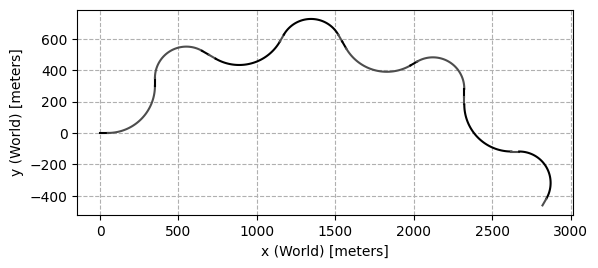

In [81]:
# Define a fixed, difficult road for evaluation
road_elements_list_difficult = [
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/300.0, "angle_in_degrees": 90.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 120.0},
    {"type": "straight", "length": 50.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/300.0, "angle_in_degrees": 90.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 120.0},
    {"type": "straight", "length": 50.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/300.0, "angle_in_degrees": 90.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 120.0},
    {"type": "straight", "length": 50.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/300.0, "angle_in_degrees": 90.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 120.0},
    {"type": "straight", "length": 50.0},
]

# Create the evaluation environment with the fixed difficult road
eval_env = create_env(None, road_elements_list_difficult)

# Render the road
eval_env.render_matplotlib_init_figure()
eval_env.render_matplotlib_plot_road()
plt.show()

## Set up the RTI-MPC Policy


In [ ]:
# Create the training environment for this level
train_env_mpc = create_env(road_randomization_params=road_randomization_params_levels[6])
train_env_mpc = DomainRandomizationWrapper(train_env_mpc, road_randomization_params=road_randomization_params_levels[6])

# Specify the policy name as a string
policy_name = "mpc"

# Create the directories where the figures are saved
mpc_figs = f"models/mpc/eval"

logdir = "logs"
file_name_suffix = "example"

# Create directory
ensure_dir(mpc_figs)

Nsim = 5000
Q = np.array([0., 100., 10., 5])       # 4x1 column vector
R = np.array([1., 1.])                 # 2x1 column vector

s_lower = np.array([[0.], [-5.], [np.deg2rad(2)], [80 / 3.6]])  # 4x1 column vector
s_upper = np.array([[np.inf], [5.], [np.deg2rad(2)], [120 / 3.6]])  # 4x1 column vector
state_ref = np.array([[0.], [0.], [0.], [100 / 3.6]])           # 4x1 column vector

# Initialize from environment observations
obs, info = train_env_mpc.reset()
p_init = obs["road_progress_at_closest_point"][0]
d_init = obs["distance_to_closest_point"][0]
mu_init = obs["heading_angle_relative_to_line"][0]
v_init = obs["vx_sensor"][0]

s_initial = np.array([[p_init], [d_init], [mu_init], [v_init]])  # 4x1 column vector
sim_seed = 69

mpc = RTIMPC(bicycle_model_parameters, Q, R,
                 s_initial, s_lower, s_upper, 0.05,
              Nsim, state_ref, train_env_mpc)

sim_time_series_dict = simulate_policy(train_env_mpc, Nsim, mpc, seed=sim_seed, verbose=1)
plot_details_list = plot_results_from_time_series_dict(train_env_mpc, sim_time_series_dict, mpc_figs, file_name_suffix, should_plot_reward=False)




Now starting simulation.


ValueError: QSQP did not solve the problem

## Model Definition and Training (SAC Policy):

In [1]:
from stable_baselines3 import SAC
# import math
model_name = "baseline_model"

TIMESTEPS_PER_EPOCH = 10000
TOTAL_EPOCHS = 32

logdir = "logs"
models_dir = f"models/{model_name}"
figs_dir_train = f"models/{model_name}/figs_train"
figs_dir_test = f"models/{model_name}/figs_test"

ensure_dirs([logdir, models_dir, figs_dir_train, figs_dir_test])

# Calculate epochs per level
levels = sorted(road_randomization_params_levels.keys())
EPOCHS_PER_LEVEL = TOTAL_EPOCHS // len(levels)

current_epoch = 0

# Start training loop over difficulty levels
for idx, level in enumerate(levels):
    print(f"Training on difficulty level {level}")
    road_randomization_params = road_randomization_params_levels[level]

    # Create the training environment for this level
    train_env = create_env(road_randomization_params=road_randomization_params)
    train_env = DomainRandomizationWrapper(train_env, road_randomization_params = road_randomization_params)
    train_env = BaselinePolicyRewardWrapper(train_env)

    if idx == 0:

      sac_params = {
            "learning_rate": 3e-4,
            "buffer_size": int(1e6),    # Replay buffer size
            "batch_size": 4096,         # Batch size
            "gamma": 0.98,              # Discount factor
            "tau": 0.005,               # Polyak averaging for target networks
            "target_entropy": "auto",   # Automatic entropy tuning
            "train_freq": 1,            # Train every step
            "gradient_steps": 1,        # Gradient steps per training step
        }

      # Define RL model
      baseline_model = SAC("MultiInputPolicy", train_env,
              **sac_params,
              verbose = 1,
              tensorboard_log=logdir)
      # For subsequent levels, set the new environment
      baseline_model.set_env(train_env)

    for epoch in range(1, EPOCHS_PER_LEVEL + 1):
        current_epoch += 1
        print(f"Epoch {current_epoch}/{TOTAL_EPOCHS} at difficulty level {level}")

        baseline_model.learn(
            total_timesteps=TIMESTEPS_PER_EPOCH,
            reset_num_timesteps=False,
            tb_log_name=f"{model_name}"
        )
        baseline_model.save(f"{models_dir}/{TIMESTEPS_PER_EPOCH * (current_epoch)}")

        # Evaluate on the most recent training road
        eval_model(train_env, baseline_model, figs_dir_train, TIMESTEPS_PER_EPOCH * current_epoch, max_steps=50000)

    # Close the training environment before moving to the next level
    train_env.close()

# Evaluate on evaluation road
eval_model(eval_env, baseline_model, figs_dir_test, TIMESTEPS_PER_EPOCH * current_epoch, max_steps=50000)

# After training, save the final model
baseline_model.save(f"{models_dir}/final_model")

ModuleNotFoundError: No module named 'stable_baselines3'

## Save Model Figures

In [ ]:
model_name = "PPO_dr_long"
model_idx = 950000

path_for_saving_figures = f"models/{model_name}/eval"
ensure_dir(path_for_saving_figures)

### Put the RL model into a policy class with a 'standardize' interface

In [ ]:
from policies.rl_policy import RLPolicy

# Put the RL model into a policy class
rl_policy = RLPolicy(model)

### Perform One simulation of the policy, plot the time series results:

In [ ]:
# Import the function for simulating the autonomous driving environment
from evaluation.evaluation_for_autonomous_driving import simulate_policy
from evaluation.evaluation_for_autonomous_driving import plot_results_from_time_series_dict

# Specify the length of the simulation in time steps
N_sim = 5000

# Specify the seed for when the simulate function resets the random number generator
sim_seed = 1;

# Call the function for simulating a given RL model
sim_time_series_dict = simulate_policy(eval_env, N_sim, rl_policy, seed=sim_seed, verbose=1)

# Call the plotting function
file_name_suffix = "example"
plot_details_list = plot_results_from_time_series_dict(eval_env, sim_time_series_dict, path_for_saving_figures, file_name_suffix, should_plot_reward=True)

### Animate the time series results:

In [ ]:
def animate_from_sim_time_series_dict(sim_time_series_dict, Ts, path_for_saving_figures):
    # Extract the necessary trajectory information from the "sim_time_series_dict"
    px_traj    = sim_time_series_dict["px"]
    py_traj    = sim_time_series_dict["py"]
    theta_traj = sim_time_series_dict["theta"]
    delta_traj = sim_time_series_dict["delta"]
    # Call the environments function to create the simulation
    ani = eval_env.unwrapped.render_matplotlib_animation_of_trajectory(px_traj, py_traj, theta_traj, delta_traj, Ts, traj_increment=3)
    # Save the animation
    ani.save(f"{path_for_saving_figures}/trajectory_animation.gif")
    print(f'Saved animation at {path_for_saving_figures}/trajectory_animation.gif')
    # Return the animation object
    return ani

In [ ]:
# Call the animation functoin
ani = animate_from_sim_time_series_dict(sim_time_series_dict, numerical_integration_parameters["Ts"], path_for_saving_figures)
# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

### Define a performance Metrics Function per simulation time series:

In [ ]:
def compute_performance_metrics_from_time_series(sim_time_series_dict):
    # Compute the statistics of the distance to the line
    abs_dist_to_line_time_series = np.abs(sim_time_series_dict["distance_to_closest_point"])
    avg_dist  = np.nanmean(abs_dist_to_line_time_series)
    std_dist  = np.nanstd(abs_dist_to_line_time_series)
    max_dist  = np.nanmax(abs_dist_to_line_time_series)

    # Compute the statistics of the speed in the forward direction (i.e., the body-frame x-axis direction)
    speed_time_series = np.abs(sim_time_series_dict["vx"])
    avg_speed = np.nanmean(speed_time_series)
    std_speed = np.nanstd(speed_time_series)
    max_speed = np.nanmax(speed_time_series)
    min_speed = np.nanmin(speed_time_series)

    # Return the results
    return {
        "avg_dist"   :  avg_dist,
        "std_dist"   :  std_dist,
        "max_dist"   :  max_dist,
        "avg_speed"  :  avg_speed * 3.6,
        "std_speed"  :  std_speed * 3.6,
        "max_speed"  :  max_speed * 3.6,
        "min_speed"  :  min_speed * 3.6,
    }


### Run the Performance Metric Function for one simulation:

In [ ]:
# Simulate with the same seed as above to check that it gets the results consistent
sim_seed = 1;
sim_time_series_dict = simulate_policy(eval_env, N_sim, rl_policy, seed=sim_seed, verbose=1)

# Call the function for computing the performance metrics
pm_dict = compute_performance_metrics_from_time_series(sim_time_series_dict)

# Display the performance metric values
print("Performance Metric dictionary:")
print(pm_dict)